In [1]:
from sklearn.cluster import SpectralClustering
import networkx as nx
import numpy as np
import scipy as sp
import matplotlib
import time
import matplotlib.pyplot as plt
from numpy import linalg as LA
import os
%matplotlib inline

## Reproducing the results

In [81]:
# Load the data
np.random.seed(7)
def read_graph(filepath, source_graph=None):
    # Use the largest connected component from the graph
    if source_graph is None:
        graph = nx.read_edgelist(filepath, nodetype=int).to_undirected()
    else:
        graph = source_graph
    graph = max(nx.connected_component_subgraphs(graph), key=len)
    
    # Split the graph edges into train and test
    random_edges = list(graph.edges())
    np.random.shuffle(random_edges)
    train_edges = random_edges[:graph.number_of_edges()//2]
    test_edges = random_edges[graph.number_of_edges()//2:]
    
    # Create the training graph
    train_graph = nx.Graph()
    train_graph.add_edges_from(train_edges)
    train_graph = max(nx.connected_component_subgraphs(train_graph), key=len)
    
    # Create the test graph
    test_graph = nx.Graph()
    test_graph.add_edges_from(test_edges)
    
    return train_graph, test_graph

def generate_dangling_random_graph():
    graph = nx.gaussian_random_partition_graph(200, 100, 10, 0.4, 0.05)
    graph.add_path([1, 300, 1234, 500, 280, 267, 221, 500, 300, 267, 221])
    graph.add_path([2, 301, 1231, 501, 281, 261, 222, 501, 301, 261, 222])
    graph.add_path([182, 3012, 12312, 5012, 2812, 2612, 2222, 5021, 3021, 2621, 2222])
    return graph

In [82]:
# Select a graph to run experiments on
# train_graph, test_graph = read_graph("./dataset/0.edges")
# train_graph, test_graph = read_graph("./dataset/twitter")
# train_graph, test_graph = read_graph("./dataset/google2")
# train_graph, test_graph = read_graph("./dataset/facebook.edges")
# train_graph, test_graph = read_graph("./dataset/gnutella08.txt")
# train_graph, test_graph = read_graph("./dataset/wiki-Vote.txt")
# train_graph, test_graph = read_graph("./dataset/as20000102.txt")
# train_graph, test_graph = read_graph("./dataset/as19991212.txt")
# train_graph, test_graph = read_graph("./dataset/ca-GrQc.txt")
# train_graph, test_graph = read_graph("./dataset/oregon1_010407.txt")
# train_graph, test_graph = read_graph('', nx.karate_club_graph())
# train_graph, test_graph = read_graph('', nx.davis_southern_women_graph())
# train_graph, test_graph = read_graph('', nx.florentine_families_graph())
train_graph, test_graph = read_graph('', generate_dangling_random_graph())

In [83]:
# Compare the eigenvectors of the markov matrix of the vanilla and regularised graphs
def get_eigen(A):
    DS = np.diag(1. / np.sqrt(np.ravel((np.sum(A, 1)))))
    L = np.identity(np.shape(A)[0]) - np.matmul(np.matmul(DS, A), DS)
    val, vec = LA.eigh(L)
    return 1 - val, np.matmul(DS, vec).real

sorted_nodes = list(train_graph.nodes())
sorted_nodes.sort()
S = nx.to_numpy_matrix(train_graph, nodelist=sorted_nodes)

# Tao is initialised with the average degree of the graph
N = train_graph.number_of_nodes()
tao = train_graph.number_of_edges() * 2 / N
SR = S + tao / N

val_van, vec_van = get_eigen(S)
val_reg, vec_reg = get_eigen(SR)

In [84]:
print(tao / N)
print(train_graph.number_of_edges())
print(test_graph.number_of_edges())

0.10950624628197501
2301
2311


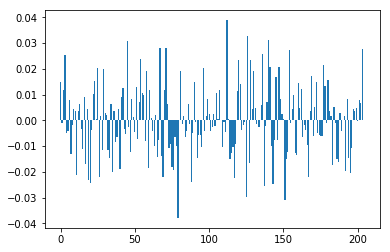

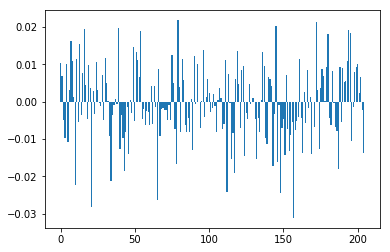

In [85]:
# Compare the eigenvectors of the laplacian of the two graphs
def plot_array(eigenval):
    plt.bar(np.arange(len(eigenval)), eigenval)
    plt.show()
    
plot_array(np.ravel(vec_van[1, :]))
plot_array(np.ravel(vec_reg[1, :]))
# plot_array(np.ravel(vec_van[:, 4]), np.ravel(vec_reg[:, 4]))

In [86]:
# Compute the number of nodes in the smallest partition set.
sc_van = SpectralClustering(2, affinity='precomputed', n_init=100).fit(S)
sc_reg = SpectralClustering(2, affinity='precomputed', n_init=100).fit(SR)

In [87]:
# Compute the size of the smallest partition
van_min_part_size = min(np.sum(sc_van.labels_), N - np.sum(sc_van.labels_))
reg_min_part_size = min(np.sum(sc_reg.labels_), N - np.sum(sc_reg.labels_))
print(van_min_part_size)
print(reg_min_part_size)

3
80


In [88]:
# Compute the conductange of the smallest set
from networkx.algorithms.cuts import conductance

sorted_nodes = np.array(sorted_nodes)
van_nodes_with_label = sorted_nodes[sc_van.labels_ == 1]
reg_nodes_with_label = sorted_nodes[sc_reg.labels_ == 1]

print("Vanilla conductance on train: {}".format(conductance(train_graph, van_nodes_with_label)))
print("CoreCut conductance on train: {}".format(conductance(train_graph, reg_nodes_with_label)))
print("Vanilla conductance on test: {}".format(conductance(test_graph, van_nodes_with_label)))
print("CoreCut conductance on test: {}".format(conductance(test_graph, reg_nodes_with_label)))

Vanilla conductance on train: 0.2
CoreCut conductance on train: 0.18401102687801515
Vanilla conductance on test: 1.0
CoreCut conductance on test: 0.17255434782608695


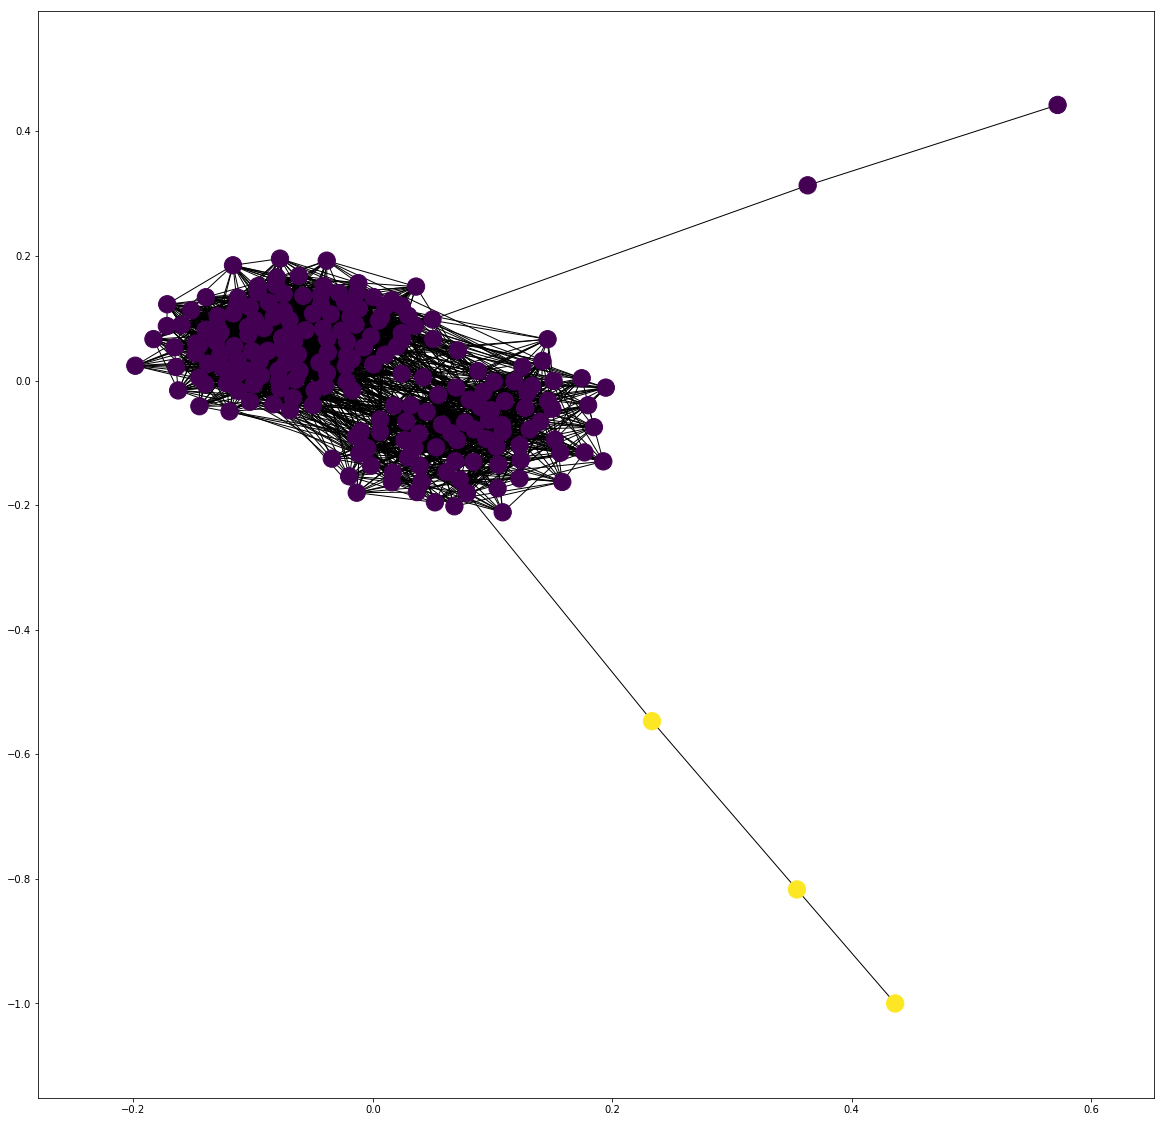

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20));
nx.draw_networkx(train_graph, ax=ax, with_labels=False, nodelist=list(sorted_nodes), node_color=sc_van.labels_)

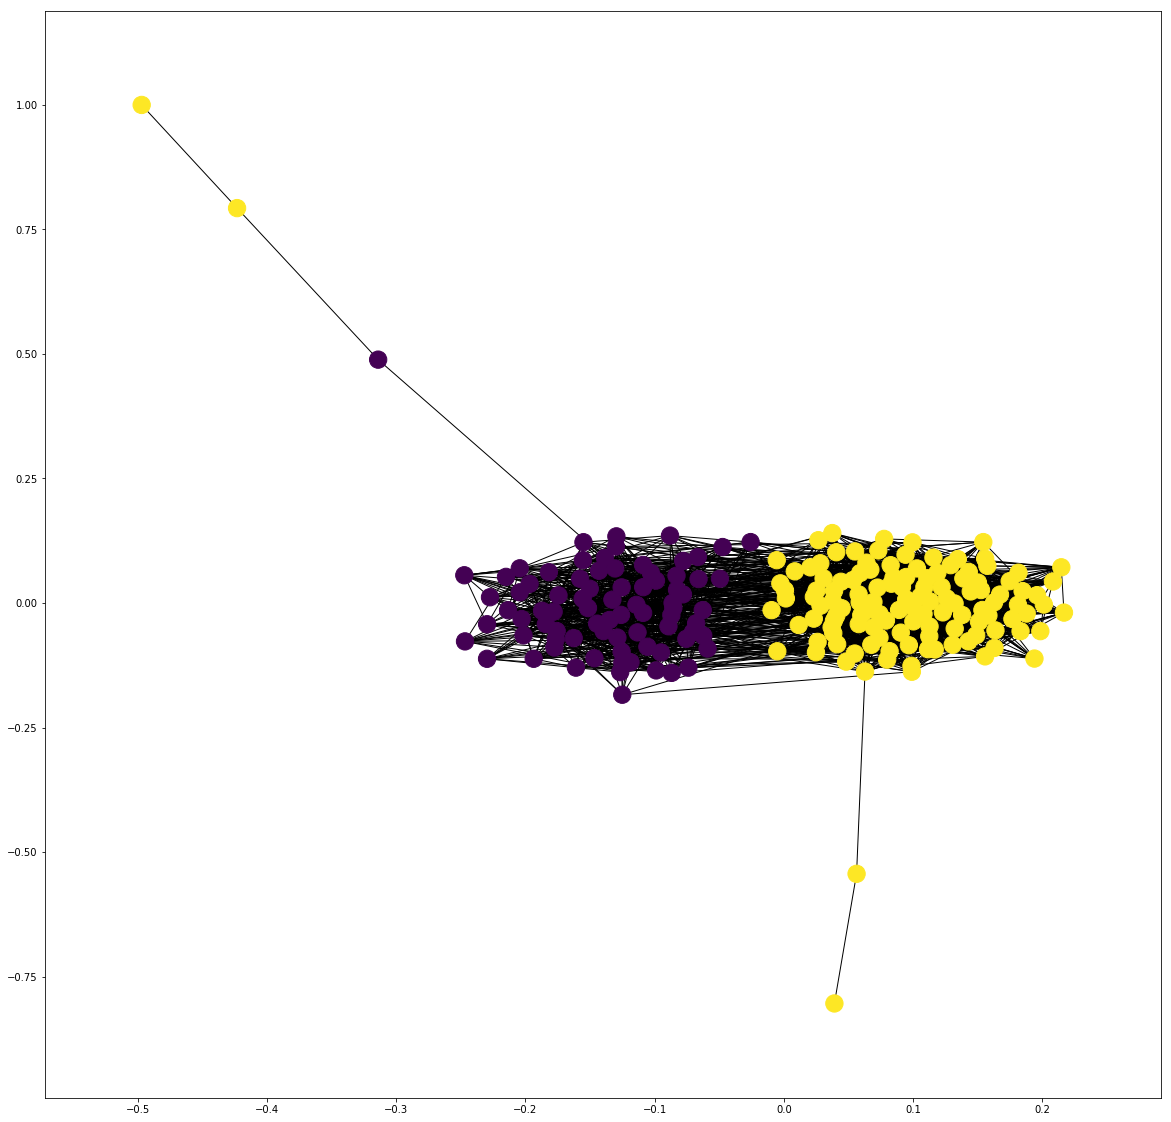

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20));
nx.draw_networkx(train_graph, ax=ax, with_labels=False, nodelist=list(sorted_nodes), node_color=(1 - sc_reg.labels_))

In [12]:
# Bechmark the execution time for the computation of eigenvalues for the two matrices
def benchmark(fct):   
    start = time.time()
    fct()
    end = time.time()
    return end-start

van_times, reg_times = [], []
runs = 10

for run in range(runs):
    van_times.append(benchmark(lambda: get_eigen(S)))
    reg_times.append(benchmark(lambda: get_eigen(SR)))

print("{}+-{}".format(np.mean(van_times), np.std(van_times)))
print("{}+-{}".format(np.mean(reg_times), np.std(reg_times)))

0.014528155326843262+-0.0037056355271299275
0.012521696090698243+-0.002551631982933928


## Experiments with more clusters on radom graphs

In [104]:
def generate_dangling_random_graph():
    graph = nx.gaussian_random_partition_graph(400, 100, np.inf, 0.4, 0.01)
    graph.add_path([1, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007])
    graph.add_path([150, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007])
    graph.add_path([350, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007])
    return graph

rgraph = generate_dangling_random_graph()
S = nx.to_numpy_matrix(rgraph)
SR = S + (rgraph.number_of_edges() * 2 / np.shape(S)[0]**2)

In [105]:
sc_van = SpectralClustering(4, affinity='precomputed', n_init=1000).fit(S)
sc_reg = SpectralClustering(4, affinity='precomputed', n_init=1000).fit(SR)

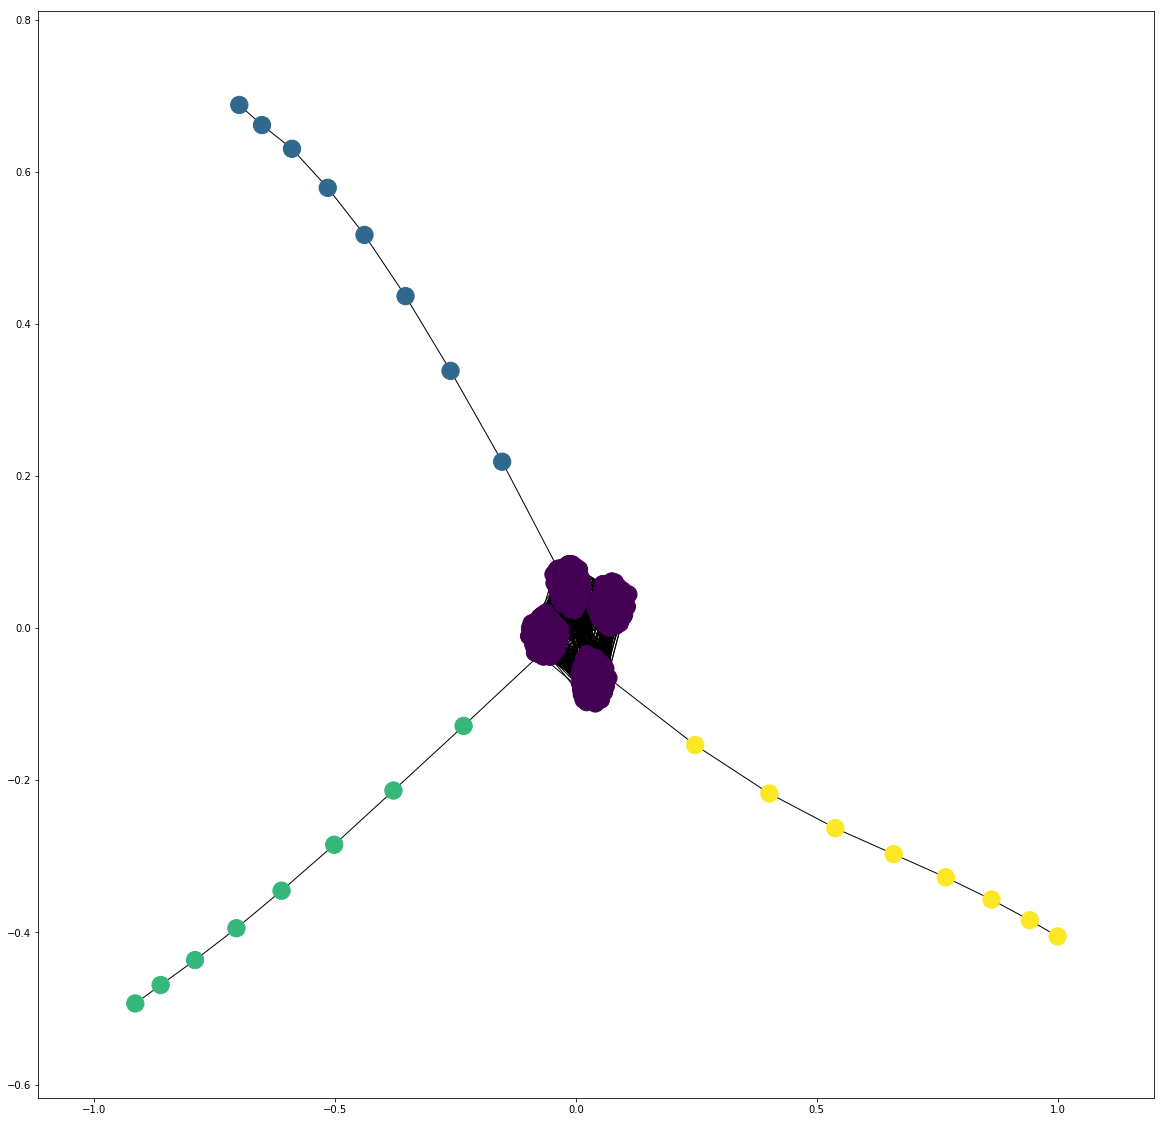

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20));
nx.draw_networkx(rgraph, ax=ax, with_labels=False, nodelist=rgraph.nodes(), node_color=sc_van.labels_)

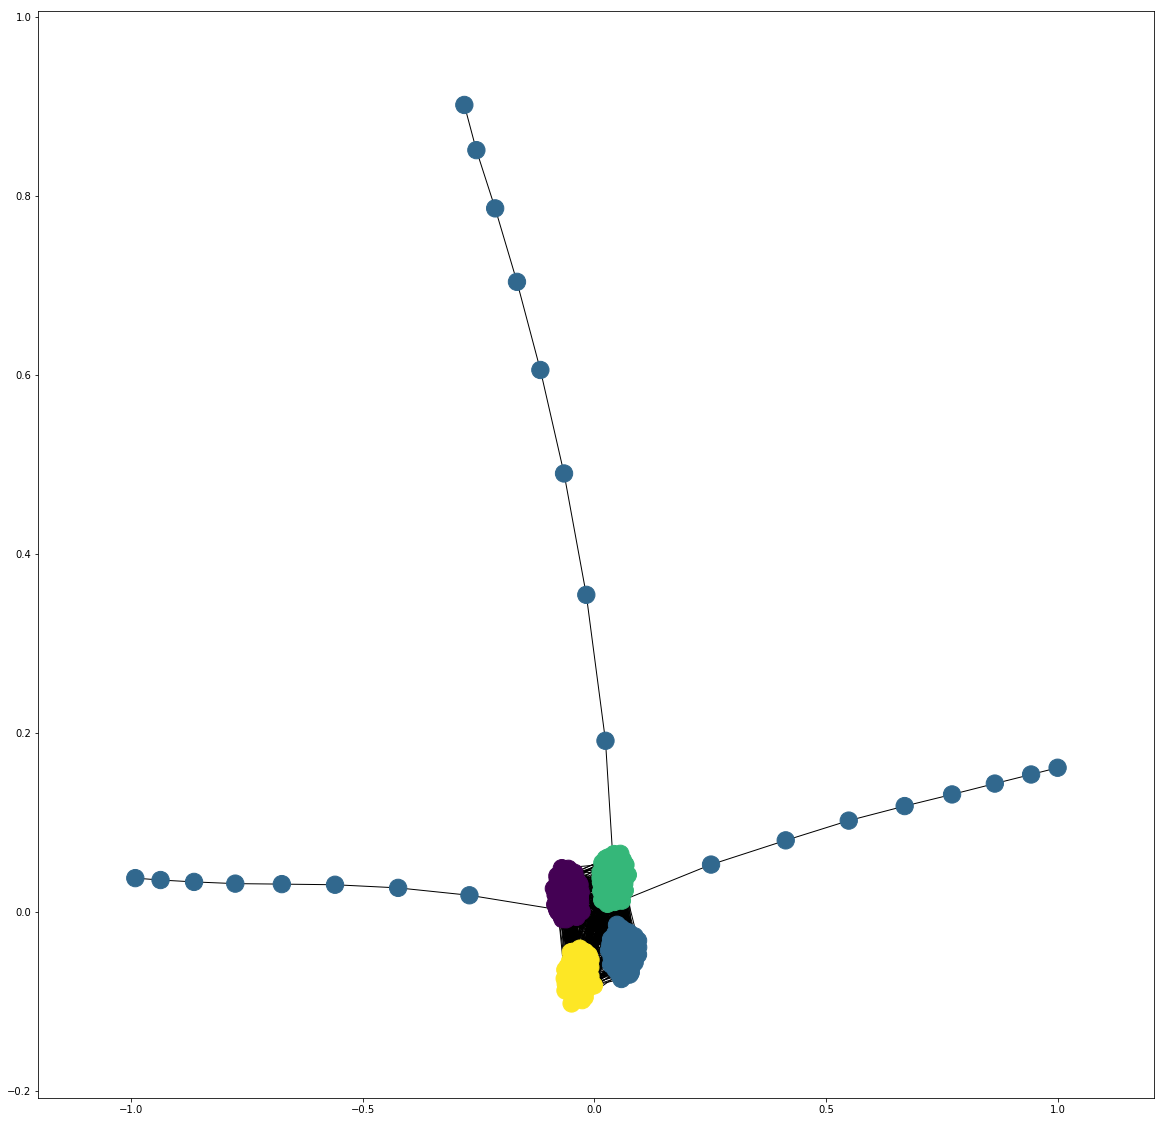

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20));
nx.draw_networkx(rgraph, ax=ax, with_labels=False, nodelist=rgraph.nodes(), node_color=sc_reg.labels_)

## Experiments with more clusters on real graphs

### Showing that regularisation reduces the variance of the cluster size

In [212]:
# train, test = read_graph("./dataset/twitter")
train, test = read_graph("./dataset/email-Eu-core.txt")
S = nx.to_numpy_matrix(train)

# Tao is initialised with the average degree of the graph
N = train.number_of_nodes()
tao = train.number_of_edges() * 2 / N
SR = S + tao / N

val_van, vec_van = get_eigen(S)
val_reg, vec_reg = get_eigen(SR)

In [179]:
np.random.seed(9)
size_std_van, size_std_reg = [], []
def size_std(labels):
    sizes = np.bincount(labels)
    return np.std(sizes)

def avg_conductance(labels, nodes, graph):
    conductances = []
    for label in np.unique(labels):
        partition = np.ravel(nodes[labels == label])
        conductances.append(conductance(graph, partition))
    return np.mean(conductances)
        

clusters = 20

cond_van, cond_reg = [], []
cond_tvan, cond_treg = [], []
nodes = np.array(train.nodes())
for number_of_clusters in range(2, clusters):
    van = SpectralClustering(number_of_clusters, affinity='precomputed', n_init=10).fit(S)
    reg = SpectralClustering(number_of_clusters, affinity='precomputed', n_init=10).fit(SR)
    
    size_std_van.append(size_std(van.labels_))    
    size_std_reg.append(size_std(reg.labels_))
    
    cond_van.append(avg_conductance(van.labels_, nodes, train))
    cond_reg.append(avg_conductance(reg.labels_, nodes, train))   
    
    cond_tvan.append(avg_conductance(van.labels_, nodes, test))
    cond_treg.append(avg_conductance(reg.labels_, nodes, test))  

<Container object of 18 artists>

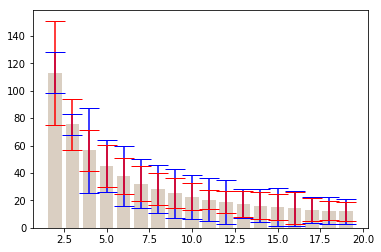

In [180]:
fig, ax = plt.subplots()
mean = N / np.arange(2, clusters)
ax.bar(np.arange(2, clusters), mean, yerr=size_std_van, alpha=0.2, align='center', ecolor='blue', capsize=10)
ax.bar(np.arange(2, clusters), mean, yerr=size_std_reg, alpha=0.2, align='center', ecolor='red', capsize=10)

<Container object of 18 artists>

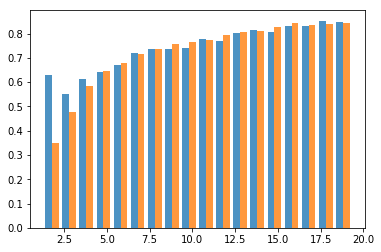

In [181]:
fig, ax = plt.subplots()
w=0.4
ax.bar(np.arange(2, clusters)-w, cond_van, width=w, alpha=0.8, align='center', ecolor='blue', capsize=10)
ax.bar(np.arange(2, clusters), cond_reg, width=w, alpha=0.8, align='center', ecolor='red', capsize=10)

<Container object of 18 artists>

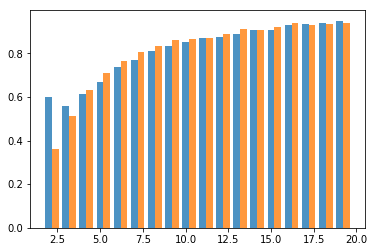

In [182]:
fig, ax = plt.subplots()
w=0.4
ax.bar(np.arange(2, clusters), cond_tvan, width=w, alpha=0.8, align='center', ecolor='blue', capsize=10)
ax.bar(np.arange(2, clusters)+w, cond_treg, width=w, alpha=0.8, align='center', ecolor='red', capsize=10)

## The effect of tao on regularisation

The graph below shows the effects of the regularisation parameter $\tau$ in the size of the minimum partition 

In [213]:
taos = np.exp(np.linspace(-10, 5, 400))
reg_sizes = []
conducts = []
conducts_test = []

nodes = np.array(train.nodes())
for tao in taos:
    SR = S + tao / N
    reg = SpectralClustering(2, affinity='precomputed', n_init=10).fit(SR)    
    
    reg_sizes.append(min(np.sum(reg.labels_), N - np.sum(reg.labels_)))
    conducts.append(avg_conductance(reg.labels_, nodes, train))
    conducts_test.append(avg_conductance(reg.labels_, nodes, test))

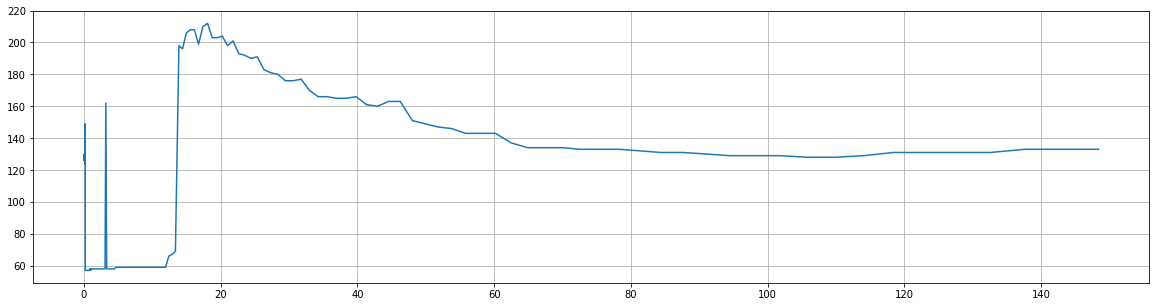

In [214]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(taos, reg_sizes)
ax.grid(True)

The effect of the $\tau$ on conductance.

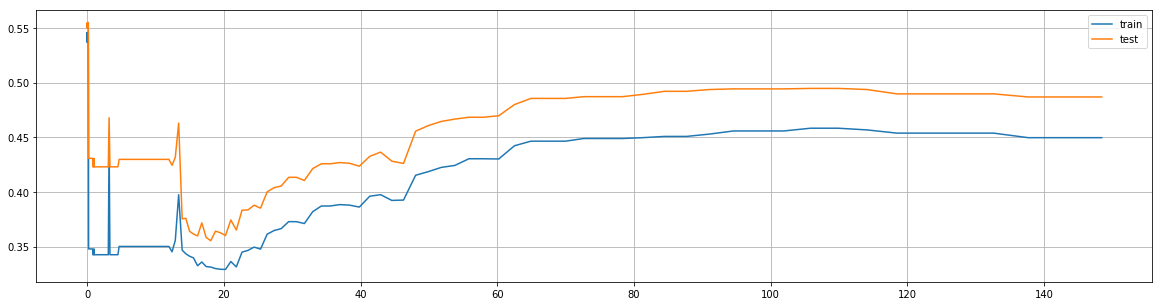

In [215]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(taos, conducts)
ax.plot(taos, conducts_test)
plt.gca().legend(('train','test'))
ax.grid(True)